In [3]:
print("Hello World")

Hello World


Using device: cpu
Loading Fashion-MNIST dataset...


100.0%
100.0%
100.0%
100.0%

Training samples: 60000
Test samples: 10000

Model Architecture:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)
Total parameters: 567,434

Starting training...


Epoch [ 1/30] Train Loss: 0.9432, Train Acc: 67.25% | Test Loss: 0.5129, Test Acc: 80.91%
Epoch [ 2/30] Train Loss: 0.5989, Train Acc: 79.32% | Test Loss: 0.4686, Test Acc: 83.01%
Epoch [ 3/30] Train Loss: 0.5397, Train Acc: 81.39% | Test Loss: 0.4378, Test Acc: 83.33%
Epoch [ 4/30] Train Loss: 0.5063, Train Acc: 82.50% | Test Loss: 0.4233, Test Acc: 84.61%
Epoch [ 5/30] Train Loss: 0.4804, Train Acc: 83.17% | Test Loss: 0.4068, Test Acc: 85.03%
Epoch [ 6/30] Train Loss: 0.4676, Train Acc: 83.64% | Test Loss: 0.4086, Test Acc: 85.50%
Epoch [ 7/30] Train Loss: 0.4536, Train Acc: 83.99% | Test Loss: 0.3953, Test Acc: 85.33%
Epoch [ 8/30] Train Loss: 0.4418, Train Acc: 84.64% | Test Loss: 0.3902, Test Acc: 86.01%
Epoch [ 9/30] Train Loss: 0.4296, Train Acc: 84.98% | Test Loss: 0.3833, Test Acc: 86.31%
Epoch [10/30] Train Loss: 0.4213, Train Acc: 85.20% | Test Loss: 0.3822, Test Acc: 86.52%
Epoch [11/30] Train Loss: 0.3854, Train Acc: 86.62% | Test Loss: 0.3563, Test Acc: 86.85%
Epoch [12/

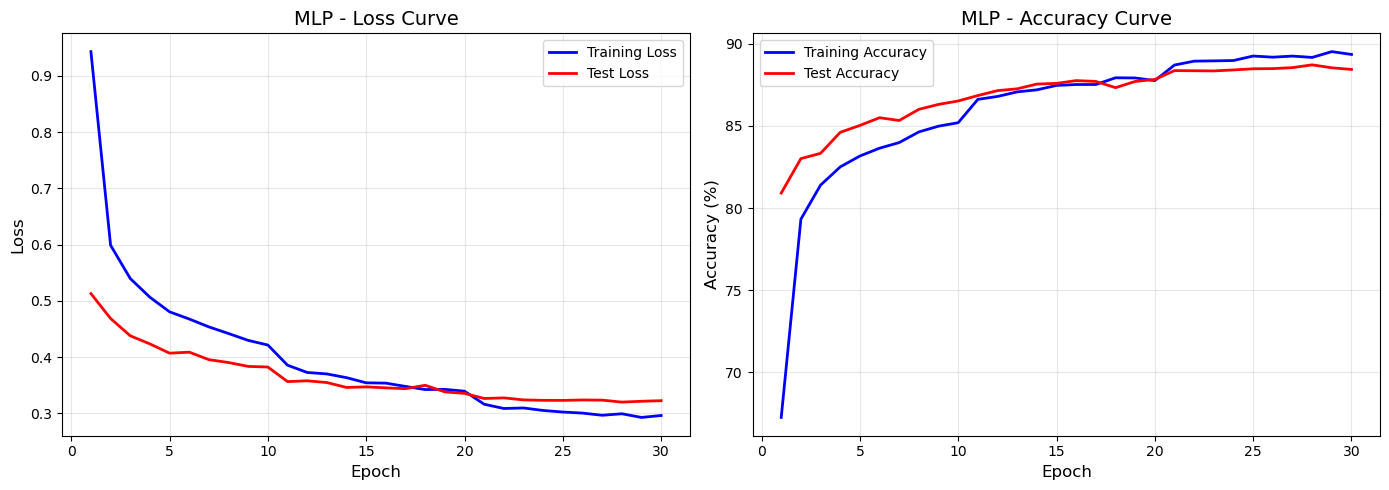

Results saved to mlp_results.png
Model saved to mlp_fashion_mnist.pth


In [2]:
"""
MLP (Multi-Layer Perceptron) for Fashion-MNIST
经典的多层感知机设计
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time

# 设置随机种子
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class MLP(nn.Module):
    """
    经典MLP设计：
    - 输入层: 784 (28x28)
    - 隐藏层1: 512 neurons with ReLU
    - 隐藏层2: 256 neurons with ReLU
    - 隐藏层3: 128 neurons with ReLU
    - 输出层: 10 classes
    包含Dropout防止过拟合
    """
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, dropout_rate=0.5):
        super(MLP, self).__init__()

        self.flatten = nn.Flatten()

        # 构建隐藏层
        layers = []
        in_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_size = hidden_size

        # 输出层
        layers.append(nn.Linear(in_size, num_classes))

        self.network = nn.Sequential(*layers)

        # 权重初始化
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.network(x)
        return x


def load_data(batch_size=128):
    """加载Fashion-MNIST数据集"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader


def train_epoch(model, train_loader, criterion, optimizer, device):
    """训练一个epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    return running_loss / len(train_loader), 100. * correct / total


def test(model, test_loader, criterion, device):
    """测试模型"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    return test_loss / len(test_loader), 100. * correct / total


def plot_results(train_losses, train_accs, test_losses, test_accs, model_name='MLP'):
    """绘制训练和测试曲线"""
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss曲线
    axes[0].plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    axes[0].plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss Curve', fontsize=14)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy曲线
    axes[1].plot(epochs, train_accs, 'b-', label='Training Accuracy', linewidth=2)
    axes[1].plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy Curve', fontsize=14)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name.lower()}_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Results saved to {model_name.lower()}_results.png")


def main():
    # 超参数
    batch_size = 128
    learning_rate = 0.001
    num_epochs = 30

    # 加载数据
    print("Loading Fashion-MNIST dataset...")
    train_loader, test_loader = load_data(batch_size)
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")

    # 创建模型
    model = MLP(
        input_size=784,
        hidden_sizes=[512, 256, 128],
        num_classes=10,
        dropout_rate=0.5
    ).to(device)

    print(f"\nModel Architecture:\n{model}")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # 训练记录
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    # 训练循环
    print("\nStarting training...")
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = test(model, test_loader, criterion, device)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch:2d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best Test Accuracy: {max(test_accs):.2f}%")

    # 绘制结果
    plot_results(train_losses, train_accs, test_losses, test_accs, 'MLP')

    # 保存模型
    torch.save(model.state_dict(), 'mlp_fashion_mnist.pth')
    print("Model saved to mlp_fashion_mnist.pth")


if __name__ == '__main__':
    main()